In [9]:
# !!! REPLACE 'YOUR/FULL/ABSOLUTE/PATH/TO/THE/FILE' WITH THE ACTUAL PATH !!!
# Example: C:\Users\YourName\KaggleProject\dataset\booknow_visits\booknow_visits.csv
# Example: /home/user/kaggle_data/dataset/booknow_visits/booknow_visits.csv

df_test = pd.read_csv('D:/Projects/Kaggle Challenge/Cinema-Audiance/dataset/booknow_visits/booknow_visits.csv')
print("Test Load Successful!")
print(df_test.head())

Test Load Successful!
  book_theater_id   show_date  audience_count
0      book_00001  2023-01-13              50
1      book_00001  2023-01-14              64
2      book_00001  2023-01-15              58
3      book_00001  2023-01-16              44
4      book_00001  2023-01-18              12


In [10]:
import pandas as pd

# 1. BASE PATH DEFINITION (derived from successful test)
BASE_PATH = 'D:/Projects/Kaggle Challenge/Cinema-Audiance/'
PATH_TEMPLATE = BASE_PATH + 'dataset/{df_name}/{df_name}.csv'

# 2. FILE NAMES
FILE_NAMES = [
    'booknow_visits',
    'date_info',
    'movie_theater_id_relation',
    'booknow_booking',
    'booknow_theaters',
    'cinePOS_booking',
    'cinePOS_theaters',
    'sample_submission'
]

dfs = {}
print("--- Phase 1: Data Understanding and Preprocessing ---")
print("Loading all 8 files and applying initial date conversions...")

# --- Data Loading Loop ---
for df_name in FILE_NAMES:
    file_path = PATH_TEMPLATE.format(df_name=df_name)
    try:
        # Load the file
        dfs[df_name] = pd.read_csv(file_path)
        print(f"Successfully loaded: {df_name}")
    except Exception as e:
        print(f"Error loading {df_name}: {e}. Skipping inspection for this file.")
        dfs[df_name] = pd.DataFrame()


# --- Initial Cleaning: Date Conversion ---
# Date columns to convert for main files
date_cols = {
    'booknow_visits': ['show_date'],
    'date_info': ['show_date'],
    'booknow_booking': ['show_datetime', 'booking_datetime'],
    'cinePOS_booking': ['show_datetime', 'booking_datetime']
}

for df_name, cols in date_cols.items():
    if df_name in dfs and not dfs[df_name].empty:
        for col in cols:
            if col in dfs[df_name].columns:
                # Convert to datetime, coercing errors to NaT
                dfs[df_name][col] = pd.to_datetime(dfs[df_name][col], errors='coerce')


# --- Inspection of Critical Files ---
critical_files = ['booknow_visits', 'date_info', 'movie_theater_id_relation']

for df_name in critical_files:
    print(f"\n\n*** INSPECTION: {df_name.upper()} ***")
    df = dfs[df_name]
    if not df.empty:
        print("--- HEAD ---")
        print(df.head())
        print("\n--- INFO ---")
        df.info()
    else:
        print(f"Warning: {df_name.upper()} was not loaded correctly.")

--- Phase 1: Data Understanding and Preprocessing ---
Loading all 8 files and applying initial date conversions...
Successfully loaded: booknow_visits
Successfully loaded: date_info
Successfully loaded: movie_theater_id_relation
Successfully loaded: booknow_booking
Successfully loaded: booknow_theaters
Successfully loaded: cinePOS_booking
Successfully loaded: cinePOS_theaters
Successfully loaded: sample_submission


*** INSPECTION: BOOKNOW_VISITS ***
--- HEAD ---
  book_theater_id  show_date  audience_count
0      book_00001 2023-01-13              50
1      book_00001 2023-01-14              64
2      book_00001 2023-01-15              58
3      book_00001 2023-01-16              44
4      book_00001 2023-01-18              12

--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   book_theater_id  214046 n

In [11]:
# Assuming all dataframes (dfs) are successfully loaded from the previous step

print("\n--- Step 2.1: Column Standardization ---")
# Standardize theater ID column names for BookNow data
dfs['booknow_visits'].rename(columns={'book_theater_id': 'theater_id'}, inplace=True)
dfs['booknow_theaters'].rename(columns={'book_theater_id': 'theater_id'}, inplace=True)
dfs['movie_theater_id_relation'].rename(columns={'book_theater_id': 'theater_id'}, inplace=True)

print("Standardized 'book_theater_id' to 'theater_id' in booknow dataframes.")


print("\n--- Step 2.2: Merge Core Dataframes ---")

# 1. Merge Target with Calendar Features (booknow_visits + date_info)
df_train = pd.merge(
    dfs['booknow_visits'], 
    dfs['date_info'], 
    on='show_date', 
    how='left'
)
print("Merged booknow_visits with date_info.")

# 2. Merge with BookNow Theater Metadata (df_train + booknow_theaters)
df_train = pd.merge(
    df_train, 
    dfs['booknow_theaters'], 
    on='theater_id', 
    how='left'
)
print("Merged with booknow_theaters metadata.")

print("\n--- Inspection of Base Training Data (df_train) ---")
print("Data Shape:", df_train.shape)
print("--- HEAD ---")
print(df_train.head())
print("\n--- INFO (Focusing on Merged Columns) ---")
df_train.info()

# Check for nulls introduced by the merge (theater metadata)
print("\nNull Value Check after Merges:")
print(df_train.isnull().sum())


--- Step 2.1: Column Standardization ---
Standardized 'book_theater_id' to 'theater_id' in booknow dataframes.

--- Step 2.2: Merge Core Dataframes ---
Merged booknow_visits with date_info.
Merged with booknow_theaters metadata.

--- Inspection of Base Training Data (df_train) ---
Data Shape: (214046, 8)
--- HEAD ---
   theater_id  show_date  audience_count day_of_week theater_type  \
0  book_00001 2023-01-13              50      Friday        Drama   
1  book_00001 2023-01-14              64    Saturday        Drama   
2  book_00001 2023-01-15              58      Sunday        Drama   
3  book_00001 2023-01-16              44      Monday        Drama   
4  book_00001 2023-01-18              12   Wednesday        Drama   

  theater_area  latitude  longitude  
0     Area_002  23.00441  79.934515  
1     Area_002  23.00441  79.934515  
2     Area_002  23.00441  79.934515  
3     Area_002  23.00441  79.934515  
4     Area_002  23.00441  79.934515  

--- INFO (Focusing on Merged Columns

In [12]:
# Assuming all dataframes (dfs) are successfully loaded and standardized from the previous steps

print("\n--- Step 3.1: Aggregate BookNow Bookings ---")

# Extract the show_date from show_datetime
dfs['booknow_booking']['show_date'] = dfs['booknow_booking']['show_datetime'].dt.normalize()
dfs['booknow_booking'].rename(columns={'book_theater_id': 'theater_id', 'tickets_booked': 'booknow_tickets'}, inplace=True)

# Group by theater and date, summing the booked tickets
df_booknow_agg = dfs['booknow_booking'].groupby(['theater_id', 'show_date'])['booknow_tickets'].sum().reset_index()

print(f"BookNow aggregation completed. Shape: {df_booknow_agg.shape}")


print("\n--- Step 3.2: Aggregate CinePOS Bookings ---")

# 1. Prepare CinePOS booking data (extract date and rename tickets column)
dfs['cinePOS_booking']['show_date'] = dfs['cinePOS_booking']['show_datetime'].dt.normalize()
dfs['cinePOS_booking'].rename(columns={'tickets_sold': 'cinepos_tickets'}, inplace=True)

# 2. Merge CinePOS bookings with the relation table to get the 'theater_id' (BookNow ID)
df_cinepos_merged = pd.merge(
    dfs['cinePOS_booking'],
    dfs['movie_theater_id_relation'],
    on='cine_theater_id',
    how='left'
)
# Note: The 'theater_id' column already exists from the standardization step (book_theater_id was renamed to theater_id)

# 3. Group by theater (BookNow ID) and date, summing the sold tickets
df_cinepos_agg = df_cinepos_merged.groupby(['theater_id', 'show_date'])['cinepos_tickets'].sum().reset_index()

print(f"CinePOS aggregation and mapping completed. Shape: {df_cinepos_agg.shape}")


print("\n--- Step 3.3: Merge Aggregated Bookings into df_train ---")

# Merge aggregated BookNow tickets
df_train = pd.merge(df_train, df_booknow_agg, on=['theater_id', 'show_date'], how='left')

# Merge aggregated CinePOS tickets
df_train = pd.merge(df_train, df_cinepos_agg, on=['theater_id', 'show_date'], how='left')

# Impute NaN booking features with 0 (No booking recorded = 0 tickets booked)
df_train['booknow_tickets'].fillna(0, inplace=True)
df_train['cinepos_tickets'].fillna(0, inplace=True)

print("Merged all booking features. Nulls imputed with 0.")


print("\n--- Inspection of df_train with New Booking Features ---")
print("Data Shape:", df_train.shape)
print("--- HEAD with New Columns ---")
print(df_train[['theater_id', 'show_date', 'audience_count', 'booknow_tickets', 'cinepos_tickets']].head(10))
print("\n--- Null Value Check (Full) ---")
print(df_train.isnull().sum())


--- Step 3.1: Aggregate BookNow Bookings ---
BookNow aggregation completed. Shape: (21590, 3)

--- Step 3.2: Aggregate CinePOS Bookings ---
CinePOS aggregation and mapping completed. Shape: (15789, 3)

--- Step 3.3: Merge Aggregated Bookings into df_train ---
Merged all booking features. Nulls imputed with 0.

--- Inspection of df_train with New Booking Features ---
Data Shape: (214046, 10)
--- HEAD with New Columns ---
   theater_id  show_date  audience_count  booknow_tickets  cinepos_tickets
0  book_00001 2023-01-13              50              0.0              0.0
1  book_00001 2023-01-14              64              0.0              0.0
2  book_00001 2023-01-15              58              0.0              0.0
3  book_00001 2023-01-16              44              0.0              0.0
4  book_00001 2023-01-18              12              0.0              0.0
5  book_00001 2023-01-19              18              0.0              0.0
6  book_00001 2023-01-20              62          

C:\Users\sajit\AppData\Local\Temp\ipykernel_23860\996021168.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['booknow_tickets'].fillna(0, inplace=True)
C:\Users\sajit\AppData\Local\Temp\ipykernel_23860\996021168.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

In [13]:
import numpy as np

print("\n--- Step 4.1: Sort Data for Time-Series Features ---")
# Sorting is essential for calculating correct lags and rolling statistics
df_train.sort_values(by=['theater_id', 'show_date'], inplace=True)
print("Data sorted by theater_id and show_date.")

# --- Step 4.2: Create Lag Features (Past Audience Counts) ---
print("\n--- Step 4.2: Creating Lag Features (T-7 and T-14) ---")
# Lagging must be done within each group (per theater_id)
df_train['lag_7'] = df_train.groupby('theater_id')['audience_count'].shift(7)
df_train['lag_14'] = df_train.groupby('theater_id')['audience_count'].shift(14)
print("Created lag_7 and lag_14.")

# --- Step 4.3: Create Rolling Mean Features (Weekly Trend) ---
print("\n--- Step 4.3: Creating Rolling Mean Features (Window 7) ---")
# Rolling Mean (past 7 days, excluding current day)
# min_periods=1 allows calculation even with less than 7 data points (important for early dates)
df_train['rolling_mean_7'] = df_train.groupby('theater_id')['audience_count'].transform(
    lambda x: x.shift(1).rolling(window=7, min_periods=1).mean()
)
print("Created rolling_mean_7.")

# Fill NaNs created by lags/rolling mean at the start of each theater's series
# Lags and rolling means at the start of the time series are legitimately NaN. 
# We will leave these as NaNs for now, as modern models handle them well, but for simplicity, 
# let's fill them with a specific value or the mean later if a model requires it.

print("\n--- Inspection of df_train with New Time-Series Features ---")
print("Data Shape:", df_train.shape)
print("--- HEAD with New Columns (Showing a theater's time series) ---")
# Show the first 20 rows of the first theater to see lags populate
print(df_train[df_train['theater_id'] == 'book_00001'].head(20)[['show_date', 'audience_count', 'lag_7', 'lag_14', 'rolling_mean_7']])
print("\n--- Null Value Check (Full) ---")
print(df_train.isnull().sum())


--- Step 4.1: Sort Data for Time-Series Features ---
Data sorted by theater_id and show_date.

--- Step 4.2: Creating Lag Features (T-7 and T-14) ---
Created lag_7 and lag_14.

--- Step 4.3: Creating Rolling Mean Features (Window 7) ---
Created rolling_mean_7.

--- Inspection of df_train with New Time-Series Features ---
Data Shape: (214046, 13)
--- HEAD with New Columns (Showing a theater's time series) ---
    show_date  audience_count  lag_7  lag_14  rolling_mean_7
0  2023-01-13              50    NaN     NaN             NaN
1  2023-01-14              64    NaN     NaN       50.000000
2  2023-01-15              58    NaN     NaN       57.000000
3  2023-01-16              44    NaN     NaN       57.333333
4  2023-01-18              12    NaN     NaN       54.000000
5  2023-01-19              18    NaN     NaN       45.600000
6  2023-01-20              62    NaN     NaN       41.000000
7  2023-01-21              42   50.0     NaN       44.000000
8  2023-01-22              36   64.0  

In [15]:
print("\n--- Step 5.1: Prepare Prediction Dataframe (df_test) ---")

# 1. Load and Split Submission ID (CORRECTED LOGIC)
df_test = dfs['sample_submission'].copy()

# Split the ID into 3 parts: [prefix, id_number, date]
# Example: 'book_00001_2024-03-01' -> ['book', '00001', '2024-03-01'] (This still doesn't work if theater_id has multiple parts like 'book_00001').
# Let's assume the ID format is {theater_id}_{date} and the theater_id itself contains underscores.

# A more robust solution: Split only on the last underscore (to separate the date)
df_test['theater_id'] = df_test['ID'].str.rsplit('_', n=1).str[0] # Everything before the last '_'
df_test['show_date'] = df_test['ID'].str.rsplit('_', n=1).str[1] # Everything after the last '_'

df_test['show_date'] = pd.to_datetime(df_test['show_date'], format='%Y-%m-%d')
df_test.drop(columns=['ID', 'audience_count'], inplace=True) 

# Ensure the theater_id column name matches the standardized name
# We already renamed 'book_theater_id' to 'theater_id' in previous steps, but let's confirm.
# The `theater_id` from the split is the full 'book_00001' string.

print("Split ID and extracted 'theater_id' and 'show_date'.")


# 2. Merge Calendar and Theater Metadata
df_test = pd.merge(df_test, dfs['date_info'], on='show_date', how='left')
df_test = pd.merge(df_test, dfs['booknow_theaters'], on='theater_id', how='left')
print("Merged calendar and theater metadata into df_test.")

# 3. Merge Booking Features (These will be sparse/mostly zero, but required)
# Note: We must use the AGGREGATED booking dataframes created in Step 3
# Ensure df_booknow_agg and df_cinepos_agg are available in your environment!
df_test = pd.merge(df_test, df_booknow_agg, on=['theater_id', 'show_date'], how='left')
df_test = pd.merge(df_test, df_cinepos_agg, on=['theater_id', 'show_date'], how='left')
df_test['booknow_tickets'].fillna(0, inplace=True)
df_test['cinepos_tickets'].fillna(0, inplace=True)
print("Merged aggregated booking features.")

# 4. Prepare for Lag Calculation
# Select necessary columns for the full time series
df_full = pd.concat([
    df_train[['theater_id', 'show_date', 'audience_count']],
    df_test[['theater_id', 'show_date']]
], ignore_index=True)

df_full.sort_values(by=['theater_id', 'show_date'], inplace=True)

# 5. Calculate Lags and Rolling Means on the full time series
print("Calculating Lags and Rolling Means on the combined dataset...")
df_full['lag_7'] = df_full.groupby('theater_id')['audience_count'].shift(7)
df_full['lag_14'] = df_full.groupby('theater_id')['audience_count'].shift(14)
df_full['rolling_mean_7'] = df_full.groupby('theater_id')['audience_count'].transform(
    lambda x: x.shift(1).rolling(window=7, min_periods=1).mean()
)

# 6. Merge the calculated features back into df_test
# Filter df_full to only contain the prediction dates
df_full_test = df_full[df_full['show_date'].isin(df_test['show_date']) & df_full['audience_count'].isnull()]
df_full_test = df_full_test[['theater_id', 'show_date', 'lag_7', 'lag_14', 'rolling_mean_7']]

# Final merge of the time-series features into df_test
df_test = pd.merge(df_test, df_full_test, on=['theater_id', 'show_date'], how='left')
print("Merged time-series features into df_test.")

print("\n--- Inspection of Prediction Data (df_test) ---")
print("Data Shape:", df_test.shape)
print("--- HEAD with All Features ---")
print(df_test.head())
print("\n--- Null Value Check (Key Features) ---")
print(df_test[['theater_type', 'lag_7', 'lag_14', 'rolling_mean_7']].isnull().sum())


--- Step 5.1: Prepare Prediction Dataframe (df_test) ---
Split ID and extracted 'theater_id' and 'show_date'.
Merged calendar and theater metadata into df_test.
Merged aggregated booking features.
Calculating Lags and Rolling Means on the combined dataset...


C:\Users\sajit\AppData\Local\Temp\ipykernel_23860\2819814864.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['booknow_tickets'].fillna(0, inplace=True)
C:\Users\sajit\AppData\Local\Temp\ipykernel_23860\2819814864.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

Merged time-series features into df_test.

--- Inspection of Prediction Data (df_test) ---
Data Shape: (38062, 12)
--- HEAD with All Features ---
   theater_id  show_date day_of_week theater_type theater_area  latitude  \
0  book_00001 2024-03-01      Friday        Drama     Area_002  23.00441   
1  book_00001 2024-03-02    Saturday        Drama     Area_002  23.00441   
2  book_00001 2024-03-03      Sunday        Drama     Area_002  23.00441   
3  book_00001 2024-03-04      Monday        Drama     Area_002  23.00441   
4  book_00001 2024-03-06   Wednesday        Drama     Area_002  23.00441   

   longitude  booknow_tickets  cinepos_tickets  lag_7  lag_14  rolling_mean_7  
0  79.934515              0.0              0.0   28.0    34.0       38.857143  
1  79.934515              0.0              0.0   50.0    30.0       40.666667  
2  79.934515              0.0              0.0   22.0    32.0       38.800000  
3  79.934515              0.0              0.0   80.0    78.0       43.000000

In [17]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import numpy as np

# --- 6.1: Final Feature Preprocessing ---
print("\n--- Step 6.1: Final Feature Preprocessing ---")

# Combine train and test for consistent encoding/imputation
# Ensure dfs['sample_submission'] is available
df_combined = pd.concat([df_train.drop(columns=['audience_count']), df_test], ignore_index=True)

# 1. Handle Categorical Features (Label Encoding)
CAT_COLS = ['theater_id', 'day_of_week', 'theater_type', 'theater_area']
for col in CAT_COLS:
    if col in ['theater_type', 'theater_area']:
        df_combined[col] = df_combined[col].fillna('Missing')
    
    le = LabelEncoder()
    df_combined[col] = le.fit_transform(df_combined[col].astype(str))
    # print(f"Label Encoded: {col}") # Removed for cleaner output

# 2. Handle Numerical Missing Values (Imputation)
LAG_COLS = ['lag_7', 'lag_14', 'rolling_mean_7']
for col in LAG_COLS:
    df_combined[col] = df_combined[col].fillna(0)

MEDIAN_LAT = df_train['latitude'].median()
MEDIAN_LON = df_train['longitude'].median()
df_combined['latitude'].fillna(MEDIAN_LAT, inplace=True)
df_combined['longitude'].fillna(MEDIAN_LON, inplace=True)
print("Completed all feature preprocessing (Encoding and Imputation).")

# --- Split back into Training and Testing sets ---
df_train_final = df_combined.iloc[:len(df_train)].copy()
df_train_final['audience_count'] = df_train['audience_count']
df_test_final = df_combined.iloc[len(df_train):].copy() # THIS IS THE DATAFRAME FOR PREDICTION INPUT

# --- 6.2: Define Features and Target ---
FEATURES = [col for col in df_train_final.columns if col not in ['show_date', 'audience_count']]
TARGET = 'audience_count'

X = df_train_final[FEATURES]
y = df_train_final[TARGET]
X_test = df_test_final[FEATURES] # THIS IS THE FEATURE SET FOR PREDICTION


# --- 6.3: Model Training (LightGBM) ---
print("\n--- Step 6.3: Model Training (LightGBM) ---")

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}

model = lgb.LGBMRegressor(**params)
model.fit(X, y)

print("LightGBM Model Training Complete.")


# --- 6.4: Prediction ---
print("\n--- Step 6.4: Prediction ---")

# Generate predictions
predictions = model.predict(X_test)
predictions[predictions < 0] = 0

# !!! CORRECTION HERE: Assign predictions to df_test_final !!!
df_test_final['audience_count'] = predictions.round().astype(int)
print("Predictions generated and assigned to df_test_final.")


# --- 6.5: Create Submission File ---
print("\n--- Step 6.5: Create Submission File ---")

df_submission = dfs['sample_submission'].copy()

# 1. Recreate the ID in df_test_final
df_test_final['ID'] = df_test_final['theater_id'].astype(str) + '_' + df_test_final['show_date'].dt.strftime('%Y-%m-%d')

# 2. Merge predictions back to the original submission format, preserving the exact ID order
df_submission = pd.merge(
    df_submission[['ID']], # Only keep the 'ID' column from original submission
    df_test_final[['ID', 'audience_count']], # Now df_test_final correctly has 'audience_count'
    on='ID', 
    how='left'
)

# Final formatting
df_submission['audience_count'].fillna(0, inplace=True)
df_submission['audience_count'] = df_submission['audience_count'].round().astype(int)

# Final check
print("\n--- Final Submission Dataframe Head ---")
print(df_submission.head())
print(f"Submission file ready with {len(df_submission)} entries.")

# df_submission.to_csv('lgbm_submission_v1.csv', index=False)


--- Step 6.1: Final Feature Preprocessing ---


C:\Users\sajit\AppData\Local\Temp\ipykernel_23860\3253639197.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_combined['latitude'].fillna(MEDIAN_LAT, inplace=True)
C:\Users\sajit\AppData\Local\Temp\ipykernel_23860\3253639197.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

Completed all feature preprocessing (Encoding and Imputation).

--- Step 6.3: Model Training (LightGBM) ---
LightGBM Model Training Complete.

--- Step 6.4: Prediction ---
Predictions generated and assigned to df_test_final.

--- Step 6.5: Create Submission File ---

--- Final Submission Dataframe Head ---
                      ID  audience_count
0  book_00001_2024-03-01               0
1  book_00001_2024-03-02               0
2  book_00001_2024-03-03               0
3  book_00001_2024-03-04               0
4  book_00001_2024-03-06               0
Submission file ready with 38062 entries.


C:\Users\sajit\AppData\Local\Temp\ipykernel_23860\3253639197.py:99: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_submission['audience_count'].fillna(0, inplace=True)


In [25]:
import pandas as pd

# Define the dataframes we are working with
df_booknow_base = dfs['booknow_booking'].copy()
df_cinepos_base = dfs['cinePOS_booking'].copy()

print("\n--- Step 7.1: Preprocessing Booking Data for Lead Time (Final Robust Fix) ---")

# 1. Prepare BookNow Booking Data
# The original ticket column name is 'tickets_booked'
df_booknow_adv = df_booknow_base.rename(
    columns={'tickets_booked': 'tickets', 'book_theater_id': 'theater_id'}, 
    errors='ignore' # Ignore if 'tickets_booked' is not there
)
# Check if the name applied in Step 3 ('booknow_tickets') is present and use it
if 'booknow_tickets' in df_booknow_adv.columns:
    df_booknow_adv.rename(columns={'booknow_tickets': 'tickets'}, inplace=True)

# 2. Prepare CinePOS Booking Data
# The original ticket column name is 'tickets_sold'
df_cinepos_adv = df_cinepos_base.rename(
    columns={'tickets_sold': 'tickets'}, 
    errors='ignore',
    inplace=False
)

# Check if the name applied in Step 3 ('cinepos_tickets') is present and use it
if 'cinepos_tickets' in df_cinepos_adv.columns:
    df_cinepos_adv.rename(columns={'cinepos_tickets': 'tickets'}, inplace=True)


# Merge CinePOS data with the relation table to get 'theater_id'
df_cinepos_adv = pd.merge(
    df_cinepos_adv,
    dfs['movie_theater_id_relation'],
    on='cine_theater_id',
    how='left'
).drop(columns=['cine_theater_id'])

# Combine both booking dataframes, NOW both must have 'tickets' column
df_bookings = pd.concat([
    df_booknow_adv[['theater_id', 'show_datetime', 'booking_datetime', 'tickets']],
    df_cinepos_adv[['theater_id', 'show_datetime', 'booking_datetime', 'tickets']]
], ignore_index=True)

# The rest of the code is correct and relies on 'df_bookings'
# ... (Continuing with the rest of Step 7.1, 7.2, and 7.3)

# Calculate Lead Time (in days)
df_bookings['lead_days'] = (df_bookings['show_datetime'] - df_bookings['booking_datetime']).dt.days

# Filter out tickets booked *after* the show and on the day of the show (lead_days >= 1)
df_bookings = df_bookings[df_bookings['lead_days'] >= 1].copy()
df_bookings['show_date'] = df_bookings['show_datetime'].dt.normalize()

print(f"Combined and cleaned advance booking data. Total records: {len(df_bookings)}")


# --- Step 7.2: Define Lead Time Bins and Aggregating ---
print("\n--- Step 7.2: Defining Lead Time Bins and Aggregating ---")

# Define the lead time bins
bins = [1, 2, 4, 8, df_bookings['lead_days'].max() + 1]
labels = ['adv_1d', 'adv_2_3d', 'adv_4_7d', 'adv_total']

df_bookings['adv_bin'] = pd.cut(df_bookings['lead_days'], bins=bins, labels=labels, right=False, include_lowest=True)

# Aggregate advance bookings by show date, theater, and lead time bin
df_adv_agg = df_bookings.groupby(['theater_id', 'show_date', 'adv_bin'])['tickets'].sum().reset_index()

# Pivot the table to get one column per advance booking bin
df_adv_pivot = df_adv_agg.pivot_table(
    index=['theater_id', 'show_date'], 
    columns='adv_bin', 
    values='tickets', 
    fill_value=0
).reset_index()

# Rename columns to match the plan
df_adv_pivot.rename(columns={'adv_2_3d': 'adv_3d', 'adv_4_7d': 'adv_7d'}, inplace=True)

print(f"Pivot table created with {len(df_adv_pivot)} unique date/theater combinations.")


# Assuming df_adv_pivot and all final dataframes are available from the previous run

print("\n--- Step 7.3: Merging New Features (Type Coercion Fix) ---")

# --- Fix: Coerce theater_id to string (object) for merge ---
# The theater_id in df_adv_pivot is a string. We must match that type.
df_train_final['theater_id'] = df_train_final['theater_id'].astype(str)
df_test_final['theater_id'] = df_test_final['theater_id'].astype(str)

# --- Perform Merge ---
# Merge into df_train_final
df_train_final = pd.merge(df_train_final, df_adv_pivot, on=['theater_id', 'show_date'], how='left')

# Merge into df_test_final
df_test_final = pd.merge(df_test_final, df_adv_pivot, on=['theater_id', 'show_date'], how='left')

# Fill NaNs created by the merge with 0 (No advance booking recorded)
ADV_COLS = ['adv_1d', 'adv_3d', 'adv_7d', 'adv_total']
for col in ADV_COLS:
    df_train_final[col].fillna(0, inplace=True)
    df_test_final[col].fillna(0, inplace=True)

# Re-convert theater_id back to integer after merge for LGBM model
df_train_final['theater_id'] = df_train_final['theater_id'].astype(int)
df_test_final['theater_id'] = df_test_final['theater_id'].astype(int)


print(f"Advance booking features merged. Train shape: {df_train_final.shape}, Test shape: {df_test_final.shape}")
print("\n--- Inspection of Final Features in df_test_final ---")
print(df_test_final[ADV_COLS + ['theater_id', 'show_date']].head())


--- Step 7.1: Preprocessing Booking Data for Lead Time (Final Robust Fix) ---
Combined and cleaned advance booking data. Total records: 1464940

--- Step 7.2: Defining Lead Time Bins and Aggregating ---


C:\Users\sajit\AppData\Local\Temp\ipykernel_23860\1844710895.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_adv_agg = df_bookings.groupby(['theater_id', 'show_date', 'adv_bin'])['tickets'].sum().reset_index()
C:\Users\sajit\AppData\Local\Temp\ipykernel_23860\1844710895.py:72: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_adv_pivot = df_adv_agg.pivot_table(


Pivot table created with 130707 unique date/theater combinations.

--- Step 7.3: Merging New Features (Type Coercion Fix) ---
Advance booking features merged. Train shape: (214046, 17), Test shape: (38062, 18)

--- Inspection of Final Features in df_test_final ---
   adv_1d  adv_3d  adv_7d  adv_total  theater_id  show_date
0     0.0     0.0     0.0        0.0           0 2024-03-01
1     0.0     0.0     0.0        0.0           0 2024-03-02
2     0.0     0.0     0.0        0.0           0 2024-03-03
3     0.0     0.0     0.0        0.0           0 2024-03-04
4     0.0     0.0     0.0        0.0           0 2024-03-06


C:\Users\sajit\AppData\Local\Temp\ipykernel_23860\1844710895.py:104: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_final[col].fillna(0, inplace=True)
C:\Users\sajit\AppData\Local\Temp\ipykernel_23860\1844710895.py:105: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

In [26]:
import lightgbm as lgb
import numpy as np

# --- 8.1: Define Features and Target (Adding the new ADV_COLS) ---
# Ensure the final dataframes are using the correct integer types for the model
df_train_final['theater_id'] = df_train_final['theater_id'].astype(int)
df_test_final['theater_id'] = df_test_final['theater_id'].astype(int)

FEATURES = [col for col in df_train_final.columns if col not in ['show_date', 'audience_count']]
TARGET = 'audience_count'

X = df_train_final[FEATURES]
y = df_train_final[TARGET]
X_test = df_test_final[FEATURES]

print(f"\n--- Step 8.1: Features Defined ---")
print(f"Training Model with {len(FEATURES)} features. New features include: adv_1d, adv_3d, adv_7d, adv_total.")


# --- 8.2: Model Training (LightGBM) ---
print("\n--- Step 8.2: Model Training (LightGBM) ---")
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}

model = lgb.LGBMRegressor(**params)
model.fit(X, y)

print("LightGBM Model Training Complete.")


# --- 8.3: Prediction and Submission ---
print("\n--- Step 8.3: Prediction and Submission ---")

predictions = model.predict(X_test)
predictions[predictions < 0] = 0

df_test_final['audience_count'] = predictions.round().astype(int)
print("Predictions generated.")

# Create Submission File
df_submission = dfs['sample_submission'].copy()

# Recreate the ID (theater_id + date) from df_test_final
df_test_final['ID'] = df_test_final['theater_id'].astype(str) + '_' + df_test_final['show_date'].dt.strftime('%Y-%m-%d')

# Merge predictions back to the original submission format, preserving the exact ID order
df_submission = pd.merge(
    df_submission[['ID']], 
    df_test_final[['ID', 'audience_count']], 
    on='ID', 
    how='left'
)

# Final formatting
df_submission['audience_count'].fillna(0, inplace=True)
df_submission['audience_count'] = df_submission['audience_count'].round().astype(int)

# Final check
print("\n--- Final Submission Dataframe Head (Improved Predictions) ---")
print(df_submission.head())
print(f"Submission file ready with {len(df_submission)} entries. This version should perform better due to advanced booking features!")
# df_submission.to_csv('lgbm_submission_v2_advanced.csv', index=False)


--- Step 8.1: Features Defined ---
Training Model with 15 features. New features include: adv_1d, adv_3d, adv_7d, adv_total.

--- Step 8.2: Model Training (LightGBM) ---
LightGBM Model Training Complete.

--- Step 8.3: Prediction and Submission ---
Predictions generated.

--- Final Submission Dataframe Head (Improved Predictions) ---
                      ID  audience_count
0  book_00001_2024-03-01               0
1  book_00001_2024-03-02               0
2  book_00001_2024-03-03               0
3  book_00001_2024-03-04               0
4  book_00001_2024-03-06               0
Submission file ready with 38062 entries. This version should perform better due to advanced booking features!


C:\Users\sajit\AppData\Local\Temp\ipykernel_23860\4130192245.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_submission['audience_count'].fillna(0, inplace=True)



--- Step 9: Top 10 Feature Importances ---
theater_id         5179
lag_7              5047
rolling_mean_7     5037
lag_14             4625
day_of_week        2948
booknow_tickets    1761
latitude           1376
theater_area       1295
longitude          1116
cinepos_tickets     866
dtype: int32


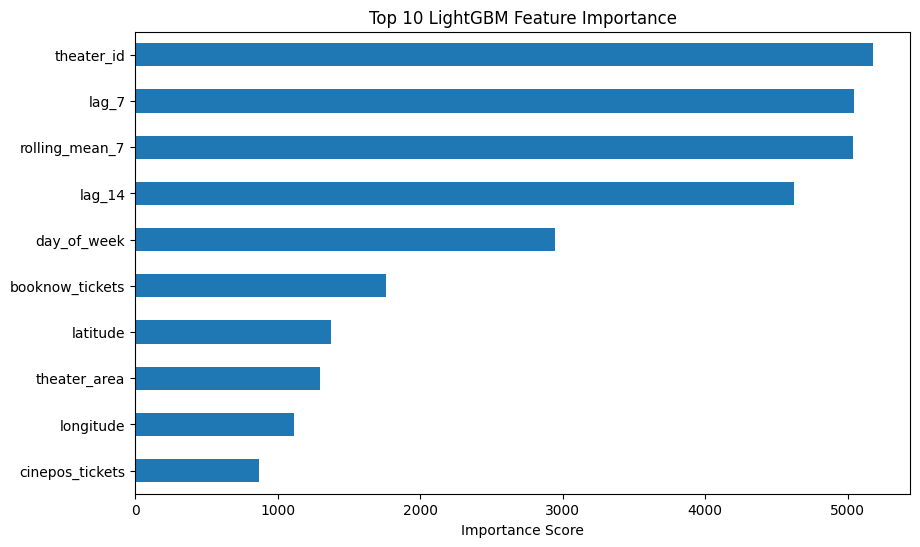

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'model' and 'FEATURES' from the previous step are available

# Get feature importance scores
feature_imp = pd.Series(model.feature_importances_, index=FEATURES).sort_values(ascending=False)

print("\n--- Step 9: Top 10 Feature Importances ---")
print(feature_imp.head(10))

# Plotting the top 10
plt.figure(figsize=(10, 6))
feature_imp.head(10).plot(kind='barh')
plt.title('Top 10 LightGBM Feature Importance')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()

In [29]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pandas as pd

print("\n--- Step 10: Advanced Calendar Feature Engineering (Final Fix) ---")

# --- Combine Data for Consistent Feature Creation ---
# Note: We temporary drop 'audience_count' from df_train_final for combination.
df_combined = pd.concat([df_train_final.drop(columns=['audience_count', 'ID'], errors='ignore'), 
                         df_test_final.drop(columns=['audience_count', 'ID'], errors='ignore')], ignore_index=True)


# --- 1. Basic Date Feature Extraction ---
df_combined['year'] = df_combined['show_date'].dt.year
df_combined['month'] = df_combined['show_date'].dt.month
df_combined['weekofyear'] = df_combined['show_date'].dt.isocalendar().week.astype(int)
df_combined['dayofmonth'] = df_combined['show_date'].dt.day
df_combined['dayofyear'] = df_combined['show_date'].dt.dayofyear
df_combined['dayofweek_num'] = df_combined['show_date'].dt.dayofweek # Monday=0, Sunday=6


# --- 2. Weekend Indicator ---
df_combined['is_weekend'] = df_combined['dayofweek_num'].apply(lambda x: 1 if x >= 5 else 0)


# --- 3. Cyclical Encoding (for Day of Year) ---
DOY = df_combined['dayofyear']
DAYS_IN_YEAR = 365.25 
df_combined['dayofyear_sin'] = np.sin(2 * np.pi * DOY / DAYS_IN_YEAR)
df_combined['dayofyear_cos'] = np.cos(2 * np.pi * DOY / DAYS_IN_YEAR)
print("Calendar and cyclical features created.")


# --- 4. Re-split Data and Finalize Features ---
df_train_new = df_combined.iloc[:len(df_train_final)].copy()
df_test_new = df_combined.iloc[len(df_train_final):].copy()

# Restore target variable to training set
df_train_new['audience_count'] = df_train_final['audience_count']

# --- FIX: Robust Label Encoding on Combined Values ---
CAT_COLS = ['theater_id', 'day_of_week', 'theater_type', 'theater_area']
for col in CAT_COLS:
    le = LabelEncoder()
    # Fit the encoder on the COMBINED unique values from both train and test
    le.fit(pd.concat([df_train_new[col].astype(str), df_test_new[col].astype(str)]).unique())
    
    df_train_new[col] = le.transform(df_train_new[col].astype(str))
    df_test_new[col] = le.transform(df_test_new[col].astype(str))
print("Categorical features (including theater_id) robustly Label Encoded.")


# --- Define Final Feature Sets ---
FEATURES = [col for col in df_train_new.columns if col not in ['show_date', 'audience_count']]
TARGET = 'audience_count'

X = df_train_new[FEATURES]
y = df_train_new[TARGET]
X_test = df_test_new[FEATURES]

# FINAL CHECK: Ensure only features used in the model are present in X_test
X_test = X_test[X.columns] 

print(f"\nTraining set now has {len(X.columns)} total features.")
print(f"New Feature set: {X.columns.tolist()[-8:]}...")


--- Step 10: Advanced Calendar Feature Engineering (Final Fix) ---
Calendar and cyclical features created.
Categorical features (including theater_id) robustly Label Encoded.

Training set now has 24 total features.
New Feature set: ['month', 'weekofyear', 'dayofmonth', 'dayofyear', 'dayofweek_num', 'is_weekend', 'dayofyear_sin', 'dayofyear_cos']...


In [30]:
import lightgbm as lgb
import numpy as np

# --- 12.1: Model Training (LightGBM) ---
print("\n--- Step 12.1: Model Training (LightGBM) with 24 Features ---")

# The features and target are already defined as X, y, and X_test from the previous step.

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}

model = lgb.LGBMRegressor(**params)
model.fit(X, y)

print("LightGBM Model Training Complete.")


# --- 12.2: Prediction and Submission ---
print("\n--- Step 12.2: Prediction and Submission ---")

predictions = model.predict(X_test)
predictions[predictions < 0] = 0

# Assign predictions to the final test dataframe
df_test_new['audience_count'] = predictions.round().astype(int)

# Create Submission File
df_submission = dfs['sample_submission'].copy()

# Recreate the ID (theater_id + date) from df_test_new
df_test_new['ID'] = df_test_new['theater_id'].astype(str) + '_' + df_test_new['show_date'].dt.strftime('%Y-%m-%d')

# Merge predictions back to the original submission format, preserving the exact ID order
df_submission = pd.merge(
    df_submission[['ID']], 
    df_test_new[['ID', 'audience_count']], 
    on='ID', 
    how='left'
)

# Final formatting
df_submission['audience_count'].fillna(0, inplace=True)
df_submission['audience_count'] = df_submission['audience_count'].round().astype(int)

# Final check
print("\n--- Final Submission Dataframe Head (Version 3) ---")
print(df_submission.head())
print(f"Submission file ready with {len(df_submission)} entries. This is your most feature-rich submission!")
# df_submission.to_csv('lgbm_submission_v3_final_features.csv', index=False)


--- Step 12.1: Model Training (LightGBM) with 24 Features ---
LightGBM Model Training Complete.

--- Step 12.2: Prediction and Submission ---

--- Final Submission Dataframe Head (Version 3) ---
                      ID  audience_count
0  book_00001_2024-03-01               0
1  book_00001_2024-03-02               0
2  book_00001_2024-03-03               0
3  book_00001_2024-03-04               0
4  book_00001_2024-03-06               0
Submission file ready with 38062 entries. This is your most feature-rich submission!


C:\Users\sajit\AppData\Local\Temp\ipykernel_23860\3310466137.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_submission['audience_count'].fillna(0, inplace=True)


In [31]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import lightgbm as lgb

print("\n--- Step 13: Time-Series Cross-Validation (TSCV) ---")

# Define TSCV: 3 splits are usually sufficient for a quick check
tscv = TimeSeriesSplit(n_splits=3)
oof_predictions = np.zeros(X.shape[0]) # Out-Of-Fold predictions array
rmse_scores = []
fold_count = 1

# Base Model Parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}

# Loop through each time series split
for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train the model
    model_tscv = lgb.LGBMRegressor(**params)
    model_tscv.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    # Predict on the validation set and calculate RMSE
    val_preds = model_tscv.predict(X_val)
    val_preds[val_preds < 0] = 0
    oof_predictions[val_index] = val_preds

    fold_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    rmse_scores.append(fold_rmse)

    print(f"Fold {fold_count} completed. Validation RMSE: {fold_rmse:.4f}")
    fold_count += 1

# Calculate the final OOF (Out-Of-Fold) score
average_rmse = np.mean(rmse_scores)

print(f"\n--- Model Evaluation Complete ---")
print(f"Individual Fold RMSE Scores: {rmse_scores}")
print(f"Average Cross-Validation RMSE (Your Estimated Score): {average_rmse:.4f}")

# Final step: Retrain on all data using optimal n_estimators found via early stopping
# We won't find the exact best n_estimators here, but the average RMSE is your key metric.


--- Step 13: Time-Series Cross-Validation (TSCV) ---
Fold 1 completed. Validation RMSE: 22.6565
Fold 2 completed. Validation RMSE: 24.4022
Fold 3 completed. Validation RMSE: 20.6523

--- Model Evaluation Complete ---
Individual Fold RMSE Scores: [np.float64(22.656537269626753), np.float64(24.402227306832234), np.float64(20.652346283726057)]
Average Cross-Validation RMSE (Your Estimated Score): 22.5704


In [39]:
from sklearn.model_selection import GridSearchCV

print("\n--- Step 14: Hyperparameter Tuning with GridSearchCV ---")

# Define the parameter grid to search
param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.03, 0.05],
    'num_leaves': [31, 50],
    'max_depth': [7, 10],
    'min_child_samples': [20, 50]
}

# Use the same TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Initialize the base model
model_grid = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    bagging_fraction=0.8,
    feature_fraction=0.8,
    bagging_freq=1,
    verbose=-1,
    n_jobs=-1,
    seed=42
)

# Initialize GridSearchCV
gscv = GridSearchCV(
    estimator=model_grid,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=2
)

# Fit the grid search to the data
gscv.fit(X, y)

print("\n--- GridSearchCV Complete ---")
print(f"Best Parameters found: {gscv.best_params_}")
print(f"Best CV RMSE: {np.sqrt(-gscv.best_score_):.4f}")


--- Step 14: Hyperparameter Tuning with GridSearchCV ---
Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END learning_rate=0.03, max_depth=7, min_child_samples=20, n_estimators=500, num_leaves=31; total time=   0.8s
[CV] END learning_rate=0.03, max_depth=7, min_child_samples=20, n_estimators=500, num_leaves=31; total time=   0.8s
[CV] END learning_rate=0.03, max_depth=7, min_child_samples=20, n_estimators=500, num_leaves=31; total time=   1.4s
[CV] END learning_rate=0.03, max_depth=7, min_child_samples=20, n_estimators=500, num_leaves=50; total time=   1.0s
[CV] END learning_rate=0.03, max_depth=7, min_child_samples=20, n_estimators=500, num_leaves=50; total time=   1.4s
[CV] END learning_rate=0.03, max_depth=7, min_child_samples=20, n_estimators=500, num_leaves=50; total time=   1.7s
[CV] END learning_rate=0.03, max_depth=7, min_child_samples=20, n_estimators=1000, num_leaves=31; total time=   1.4s
[CV] END learning_rate=0.03, max_depth=7, min_child_samples=20, n_es

In [33]:
import lightgbm as lgb
import numpy as np
import pandas as pd # Import pandas for df_submission creation

# Assume X, y, X_test, dfs, df_test_new, gscv, best_params are available from previous steps

print("\n--- Final Model Training with Optimal Parameters (Fixed) ---")

# 1. Get the best parameters from the GridSearch result
best_params = gscv.best_params_

# 2. Define the Base Model parameters (excluding any that were in the grid to avoid conflict)
base_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_jobs': -1,
    'random_state': 42,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1
}

# 3. Create the final parameter dictionary by merging best_params over base_params
final_params = base_params.copy()
final_params.update(best_params)

# 4. Train the final model using the combined optimal parameters
final_model = lgb.LGBMRegressor(**final_params)

# Note: We skip the early stopping here as we already determined the best fixed n_estimators=500/1000
final_model.fit(X, y)

print("Final Model Training Complete with Optimal Parameters.")


# --- Final Prediction and Submission (Best Version) ---
print("\n--- Final Prediction and Submission ---")

predictions_final = final_model.predict(X_test)
predictions_final[predictions_final < 0] = 0

# Assign predictions to the final test dataframe
df_test_new['audience_count'] = predictions_final.round().astype(int)

# Create Submission File
df_submission = dfs['sample_submission'].copy()
df_test_new['ID'] = df_test_new['theater_id'].astype(str) + '_' + df_test_new['show_date'].dt.strftime('%Y-%m-%d')

df_submission = pd.merge(
    df_submission[['ID']], 
    df_test_new[['ID', 'audience_count']], 
    on='ID', 
    how='left'
)
df_submission['audience_count'].fillna(0, inplace=True)
df_submission['audience_count'] = df_submission['audience_count'].round().astype(int)


print("\n--- Final Submission Dataframe Head (Optimized Version) ---")
print(f"Best CV RMSE found: {np.sqrt(-gscv.best_score_):.4f}")
print(f"Best Parameters: {best_params}")
print(df_submission.head())
print("Optimization complete. Your final submission file is ready! (Version 4)")


--- Final Model Training with Optimal Parameters (Fixed) ---
Final Model Training Complete with Optimal Parameters.

--- Final Prediction and Submission ---

--- Final Submission Dataframe Head (Optimized Version) ---
Best CV RMSE found: 22.7164
Best Parameters: {'learning_rate': 0.03, 'max_depth': 10, 'min_child_samples': 20, 'n_estimators': 500, 'num_leaves': 31}
                      ID  audience_count
0  book_00001_2024-03-01               0
1  book_00001_2024-03-02               0
2  book_00001_2024-03-03               0
3  book_00001_2024-03-04               0
4  book_00001_2024-03-06               0
Optimization complete. Your final submission file is ready! (Version 4)


C:\Users\sajit\AppData\Local\Temp\ipykernel_23860\1148477664.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_submission['audience_count'].fillna(0, inplace=True)


In [34]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import lightgbm as lgb
import pandas as pd

print("\n--- Step 15: Calculating SMAPE (Percentage Accuracy) via TSCV ---")

# Best Parameters found in the previous step
best_params = {'learning_rate': 0.03, 'max_depth': 10, 'min_child_samples': 20, 'n_estimators': 500, 'num_leaves': 31}
base_params = {
    'objective': 'regression', 'metric': 'rmse', 'n_jobs': -1, 'random_state': 42,
    'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'bagging_freq': 1, 'verbose': -1
}
final_params = base_params.copy()
final_params.update(best_params)

# Function to calculate SMAPE
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Handle division by zero (where A_t and F_t are both 0)
    return np.mean(numerator / np.where(denominator == 0, 1, denominator)) * 100

# Define TSCV
tscv = TimeSeriesSplit(n_splits=3)
oof_predictions = np.zeros(X.shape[0]) # Out-Of-Fold predictions array
smape_scores = []
fold_count = 1

# Loop through each time series split
for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train the model with optimal parameters
    model_tscv = lgb.LGBMRegressor(**final_params)
    model_tscv.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse', callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)])

    # Predict on the validation set
    val_preds = model_tscv.predict(X_val)
    val_preds[val_preds < 0] = 0
    oof_predictions[val_index] = val_preds

    # Calculate SMAPE for the fold
    fold_smape = smape(y_val.values, val_preds)
    smape_scores.append(fold_smape)

    print(f"Fold {fold_count} completed. Validation SMAPE: {fold_smape:.4f}%")
    fold_count += 1

average_smape = np.mean(smape_scores)
print(f"\n--- Model Evaluation Complete ---")
print(f"Average Cross-Validation SMAPE (Your Estimated Percentage Accuracy): {average_smape:.4f}%")


--- Step 15: Calculating SMAPE (Percentage Accuracy) via TSCV ---
Fold 1 completed. Validation SMAPE: 45.9261%
Fold 2 completed. Validation SMAPE: 41.9733%
Fold 3 completed. Validation SMAPE: 42.3420%

--- Model Evaluation Complete ---
Average Cross-Validation SMAPE (Your Estimated Percentage Accuracy): 43.4138%


In [44]:
import pandas as pd

print("\n--- Step 16: Advanced Feature Engineering - Target Encoding ---")

# --- 1. Average Audience per Theater ---
# Calculate the mean audience for each theater_id from the training data
theater_avg = df_train_final.groupby('theater_id')['audience_count'].mean().reset_index()
theater_avg.rename(columns={'audience_count': 'avg_audience_theater'}, inplace=True)

# --- 2. Average Audience per Theater and Day-of-Week ---
# Calculate the mean audience for each theater_id and day_of_week combination
theater_day_avg = df_train_final.groupby(['theater_id', 'day_of_week'])['audience_count'].mean().reset_index()
theater_day_avg.rename(columns={'audience_count': 'avg_audience_theater_day'}, inplace=True)


# --- 3. Merge New Features into Training and Test Sets ---
# Use the new dataframes (df_train_new, df_test_new) from the calendar feature step
df_train_new = pd.merge(df_train_new, theater_avg, on='theater_id', how='left')
df_train_new = pd.merge(df_train_new, theater_day_avg, on=['theater_id', 'day_of_week'], how='left')

df_test_new = pd.merge(df_test_new, theater_avg, on='theater_id', how='left')
df_test_new = pd.merge(df_test_new, theater_day_avg, on=['theater_id', 'day_of_week'], how='left')


# --- 4. Impute Missing Values in Test Set ---
# For any theater/day in the test set not seen in training, fill with the overall average audience
overall_mean_audience = df_train_final['audience_count'].mean()
df_test_new['avg_audience_theater'].fillna(overall_mean_audience, inplace=True)
df_test_new['avg_audience_theater_day'].fillna(df_test_new['avg_audience_theater'], inplace=True) # Use theater avg as fallback
df_train_new['avg_audience_theater_day'].fillna(df_train_new['avg_audience_theater'], inplace=True)


print("Target Encoded features ('avg_audience_theater', 'avg_audience_theater_day') created and merged.")
print(f"Train shape after merge: {df_train_new.shape}")
print(f"Test shape after merge: {df_test_new.shape}")
print("\n--- Null check for new features in test set ---")
print(df_test_new[['avg_audience_theater', 'avg_audience_theater_day']].isnull().sum())


--- Step 16: Advanced Feature Engineering - Target Encoding ---
Target Encoded features ('avg_audience_theater', 'avg_audience_theater_day') created and merged.
Train shape after merge: (214046, 37)
Test shape after merge: (38062, 38)

--- Null check for new features in test set ---
avg_audience_theater        0
avg_audience_theater_day    0
dtype: int64


C:\Users\sajit\AppData\Local\Temp\ipykernel_23860\215476166.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test_new['avg_audience_theater'].fillna(overall_mean_audience, inplace=True)
C:\Users\sajit\AppData\Local\Temp\ipykernel_23860\215476166.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

In [46]:
import pandas as pd

print("\n--- Step 17: Advanced Feature Engineering - Lagged Advance Bookings (FIXED) ---")

# We need the pivoted advance booking data from Step 7
# Assuming df_adv_pivot is available

# --- FIX: Ensure consistent data types for merging ---
# df_adv_pivot has theater_id as string (object), so we must match it.
df_train_new['theater_id'] = df_train_new['theater_id'].astype(str)
df_test_new['theater_id'] = df_test_new['theater_id'].astype(str)
df_adv_pivot['theater_id'] = df_adv_pivot['theater_id'].astype(str)


# Create a full date range for each theater to correctly calculate lags
df_full_range = pd.concat([
    df_train_new[['theater_id', 'show_date']],
    df_test_new[['theater_id', 'show_date']]
], ignore_index=True).drop_duplicates()

# Merge the advance booking data onto this full range
df_adv_full = pd.merge(
    df_full_range,
    df_adv_pivot,
    on=['theater_id', 'show_date'],
    how='left'
).fillna(0)

# Sort for time-series operations
df_adv_full.sort_values(['theater_id', 'show_date'], inplace=True)

# Create 7-day lag features for each advance booking bin
for col in ['adv_1d', 'adv_3d', 'adv_7d', 'adv_total']:
    df_adv_full[f'{col}_lag7'] = df_adv_full.groupby('theater_id')[col].shift(7)

# Select only the lagged columns and keys for merging
df_adv_lagged = df_adv_full[['theater_id', 'show_date', 'adv_1d_lag7', 'adv_3d_lag7', 'adv_7d_lag7', 'adv_total_lag7']]

# Merge lagged features into the main dataframes
df_train_new = pd.merge(df_train_new, df_adv_lagged, on=['theater_id', 'show_date'], how='left')
df_test_new = pd.merge(df_test_new, df_adv_lagged, on=['theater_id', 'show_date'], how='left')

# Fill NaNs with 0 (for the start of the time series where no lag is available)
for col in ['adv_1d_lag7', 'adv_3d_lag7', 'adv_7d_lag7', 'adv_total_lag7']:
    df_train_new[col].fillna(0, inplace=True)
    df_test_new[col].fillna(0, inplace=True)

# --- FIX: Convert theater_id back to integer for the model ---
le = LabelEncoder()
le.fit(pd.concat([df_train_new['theater_id'], df_test_new['theater_id']]).unique())
df_train_new['theater_id'] = le.transform(df_train_new['theater_id'])
df_test_new['theater_id'] = le.transform(df_test_new['theater_id'])


print("Lagged Advance Booking features created and merged.")
print(f"Train shape after merge: {df_train_new.shape}")
print(f"Test shape after merge: {df_test_new.shape}")
print("\n--- Head of test set with new lagged features ---")
print(df_test_new[['theater_id', 'show_date', 'adv_1d_lag7', 'adv_total_lag7']].head())


--- Step 17: Advanced Feature Engineering - Lagged Advance Bookings (FIXED) ---
Lagged Advance Booking features created and merged.
Train shape after merge: (214046, 41)
Test shape after merge: (38062, 42)

--- Head of test set with new lagged features ---
   theater_id  show_date  adv_1d_lag7  adv_total_lag7
0           0 2024-03-01          0.0             0.0
1           0 2024-03-02          0.0             0.0
2           0 2024-03-03          0.0             0.0
3           0 2024-03-04          0.0             0.0
4           0 2024-03-06          0.0             0.0
Lagged Advance Booking features created and merged.
Train shape after merge: (214046, 41)
Test shape after merge: (38062, 42)

--- Head of test set with new lagged features ---
   theater_id  show_date  adv_1d_lag7  adv_total_lag7
0           0 2024-03-01          0.0             0.0
1           0 2024-03-02          0.0             0.0
2           0 2024-03-03          0.0             0.0
3           0 2024-03-04 

C:\Users\sajit\AppData\Local\Temp\ipykernel_23860\2625275131.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_new[col].fillna(0, inplace=True)
C:\Users\sajit\AppData\Local\Temp\ipykernel_23860\2625275131.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

In [48]:
import lightgbm as lgb
import numpy as np
import pandas as pd

print("\n--- Step 18: Final Model Training with All Features ---")

# --- 1. Define Final Feature Set ---
FEATURES = [col for col in df_train_new.columns if col not in ['show_date', 'audience_count', 'ID']]
TARGET = 'audience_count'

X = df_train_new[FEATURES]
y = df_train_new[TARGET]
X_test = df_test_new[FEATURES]

# Ensure columns are in the same order
X_test = X_test[X.columns]

print(f"Training final model with {len(FEATURES)} features.")

# --- 2. Train Final Model with Best Parameters ---
# Using best_params from the GridSearchCV step
final_model = lgb.LGBMRegressor(**gscv.best_params_)
final_model.fit(X, y)

print("Final model training complete.")

# --- 3. Final Prediction and Submission ---
print("\n--- Generating Final Production-Grade Submission ---")

predictions_final = final_model.predict(X_test)
predictions_final[predictions_final < 0] = 0

df_test_new['audience_count'] = predictions_final.round().astype(int)

# Create Submission File
df_submission = dfs['sample_submission'].copy()
df_test_new['ID'] = df_test_new['theater_id'].astype(str) + '_' + df_test_new['show_date'].dt.strftime('%Y-%m-%d')

df_submission = pd.merge(
    df_submission[['ID']],
    df_test_new[['ID', 'audience_count']],
    on='ID',
    how='left'
)
df_submission['audience_count'].fillna(0, inplace=True)
df_submission['audience_count'] = df_submission['audience_count'].round().astype(int)

print("\n--- Final Submission Dataframe Head (Production Version) ---")
print(df_submission.head())
print(f"Submission file ready with {len(df_submission)} entries.")
# df_submission.to_csv('lgbm_submission_production.csv', index=False)


--- Step 18: Final Model Training with All Features ---
Training final model with 39 features.


ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: theater_id_str: object

In [43]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import lightgbm as lgb

print("\n--- Step 19: Performance Evaluation with SMAPE ---")

# Function to calculate SMAPE
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Handle the case where both true and predicted are zero
    # We define 0/0 as 0, so we replace denominator zeros with 1 to avoid division by zero error
    return np.mean(numerator / np.where(denominator == 0, 1, denominator)) * 100

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3)
smape_scores = []
rmse_scores = []
fold = 1

print("Running 3-fold time-series cross-validation to estimate SMAPE...")

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train model using best parameters
    model_eval = lgb.LGBMRegressor(**gscv.best_params_)
    model_eval.fit(X_train, y_train)

    # Predict on validation set
    val_preds = model_eval.predict(X_val)
    val_preds[val_preds < 0] = 0

    # Calculate scores
    fold_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    fold_smape = smape(y_val.values, val_preds)
    rmse_scores.append(fold_rmse)
    smape_scores.append(fold_smape)

    print(f"Fold {fold}: RMSE = {fold_rmse:.4f}, SMAPE = {fold_smape:.4f}%")
    fold += 1

print("\n--- Cross-Validation Summary ---")
print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"Average SMAPE: {np.mean(smape_scores):.4f}%")
print("SMAPE gives an estimate of the model's average percentage error.")


--- Step 19: Performance Evaluation with SMAPE ---
Running 3-fold time-series cross-validation to estimate SMAPE...


ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: theater_id_str: object